In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns   
import caveclient
import standard_transform
import os
import scipy
%matplotlib inline

In [2]:
soma_df = pd.read_feather('/data/Microns Soma Features v661/soma_features_v661.feather')

In [3]:
soma_df['soma_volume_um'] = soma_df.soma_volume_nm/(1000*1000*1000)

In [4]:
client = caveclient.CAVEclient('minnie65_phase3_v1', auth_token=os.environ['API_SECRET'])

In [5]:
ct_df=client.materialize.query_table('aibs_metamodel_mtypes_v661_v2', split_positions=True, desired_resolution=(1,1,1))

Using deprecated pyarrow serialization method, please upgrade CAVEClient>=5.9.0 with pip install --upgrade caveclient


In [6]:
from standard_transform.datasets import minnie_transform_nm
tform=minnie_transform_nm()
pos_tform=np.array(tform.apply_dataframe('pt_position', ct_df))
ct_df['soma_pos_um_x']=pos_tform[:,0]
ct_df['soma_pos_um_y']=pos_tform[:,1]
ct_df['soma_pos_um_z']=pos_tform[:,2]

In [7]:
ct_df_cut=ct_df[['cell_type', 'classification_system', 'volume',
 'target_id', 'soma_pos_um_x', 'soma_pos_um_y',
 'soma_pos_um_z']]

In [8]:
soma_dfm = pd.merge(soma_df, ct_df_cut, left_on='nuc_id', right_on='target_id')


In [9]:
soma_dfm.columns, soma_dfm.shape

(Index(['soma_id', 'soma_center_mass', 'soma_volume_nm', 'soma_area_nm',
        'soma_area_to_volume', 'n_soma_syn', 'soma_syn_density', 'frac_zero',
        'nucleus_id', 'is_watertight', 'nucleus_center_mass',
        'nucleus_avg_radius', 'nucleus_volume_nm', 'nucleus_area_nm',
        'nucleus_area_to_volume_ratio', 'nucleus_aspect_ratio',
        'nucleus_is_clipped', 'fold_area_nm', 'fract_fold', 'avg_fold_depth',
        'soma_nuc_d', 'nucleus_to_soma', 'nuc_id', 'soma_volume_um',
        'cell_type', 'classification_system', 'volume', 'target_id',
        'soma_pos_um_x', 'soma_pos_um_y', 'soma_pos_um_z'],
       dtype='object'),
 (72158, 31))

In [10]:
upper_exc_cells= soma_dfm.query('classification_system=="excitatory_neuron"').query('soma_pos_um_y<300')


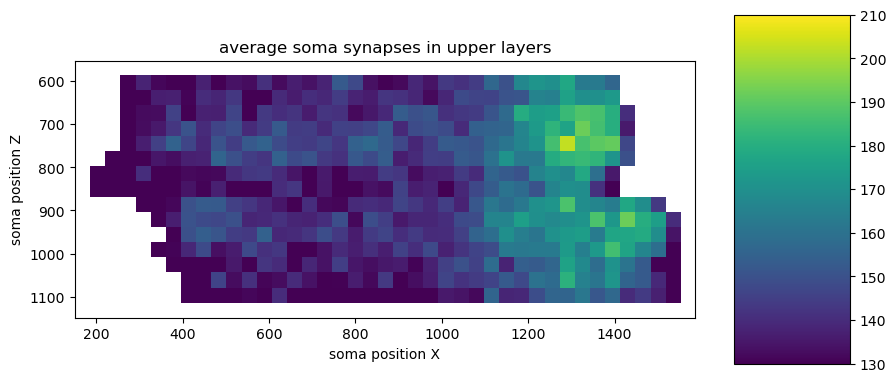

In [11]:
nbins=30
binx = np.arange(upper_exc_cells.soma_pos_um_x.min()-50, 
                   upper_exc_cells.soma_pos_um_x.max()+50, 
                   35)
biny = np.arange(upper_exc_cells.soma_pos_um_z.min()-50, 
                   upper_exc_cells.soma_pos_um_z.max()+50, 
                   35)                



mean_soma_map,x_edges,y_edges, _ = scipy.stats.binned_statistic_2d(upper_exc_cells.soma_pos_um_x, 
                                upper_exc_cells.soma_pos_um_z,
                                upper_exc_cells.n_soma_syn, statistic='mean', bins=[binx, biny])

f ,ax = plt.subplots(figsize=(10,10))
M=ax.imshow(mean_soma_map.T, extent=[binx[0], binx[-1], biny[-1], biny[0]], vmax=210,vmin=130)
ax.set_aspect('equal')
ax.set_title('average soma synapses in upper layers')
ax.set_xlabel('soma position X')
ax.set_ylabel('soma position Z')
f.colorbar(M, aspect=3)


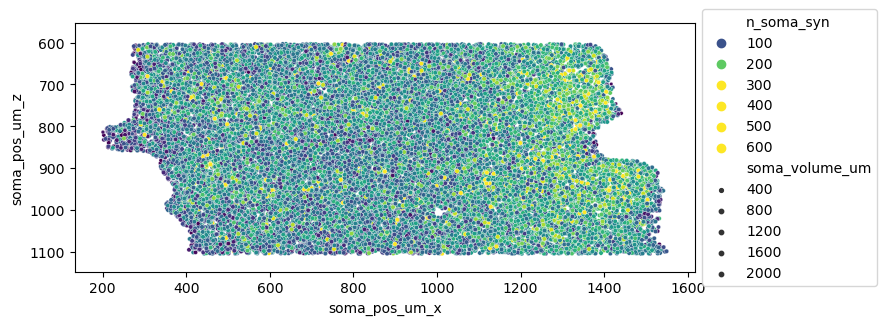

In [12]:
f, ax = plt.subplots(figsize=(8,8))

sns.scatterplot(data=upper_exc_cells,
 x='soma_pos_um_x', y='soma_pos_um_z', size='soma_volume_um', hue='n_soma_syn',
  palette=plt.cm.viridis, size_norm = (100,600), sizes=(4,10),
  hue_norm = (50,250), ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_ylim(biny[-1], biny[0])
ax.set_aspect('equal')

In [13]:
beh_df = pd.read_feather('/data/Microns In Vivo Correlation Data v1/cell_behavior_correlations.feather')

beh_df['session_scan_comb']=[f'{x.session}_{x.scan_idx}' for k,x in beh_df.iterrows()]


In [14]:
beh_dfm=pd.merge(beh_df, soma_dfm, left_on='pt_root_id', right_on='soma_id')

In [15]:
upper_beh_cells = beh_dfm.query('soma_pos_um_y<300')


Text(0.5, 1.0, 'mean correlation with pupil')

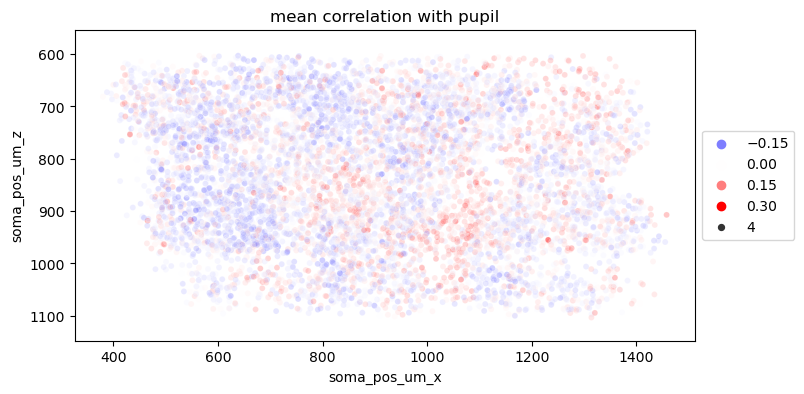

In [16]:
f, ax = plt.subplots(figsize=(8,8))

sns.scatterplot(data=upper_beh_cells,
 x='soma_pos_um_x', y='soma_pos_um_z', hue='pupil_corr',
  palette=plt.cm.bwr, size=4,alpha=.3,
  hue_norm = (-.3,.3), ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_ylim(biny[-1], biny[0])
ax.set_aspect('equal')
ax.set_title('mean correlation with pupil')

Text(0.5, 1.0, 'mean correlation with pupil')

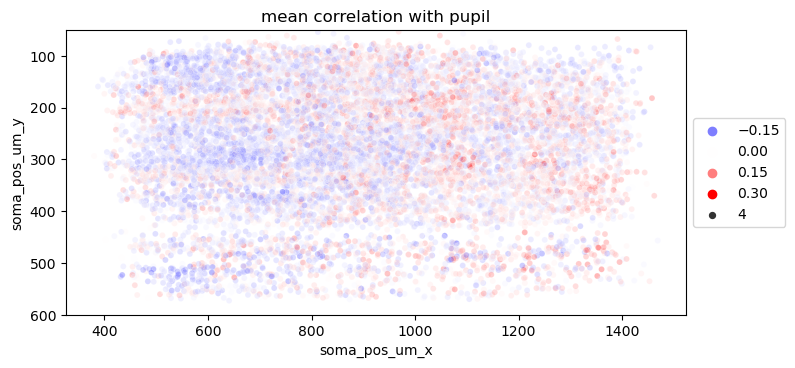

In [17]:
f, ax = plt.subplots(figsize=(8,8))



sns.scatterplot(data=beh_dfm,
 x='soma_pos_um_x', y='soma_pos_um_y', hue='pupil_corr',
  palette=plt.cm.bwr, size=4,alpha=.3,
  hue_norm = (-.3,.3), ax=ax)

# sns.scatterplot(data=beh_dfm.query('session==9').query('scan_idx==6'),
#  x='soma_pos_um_x', y='soma_pos_um_y', linewidth=0, c='k',
#    size=1.5,alpha=1, ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))



ax.set_ylim(600, 50)
ax.set_aspect('equal')
ax.set_title('mean correlation with pupil')

Text(0.5, 1.0, 'cell types')

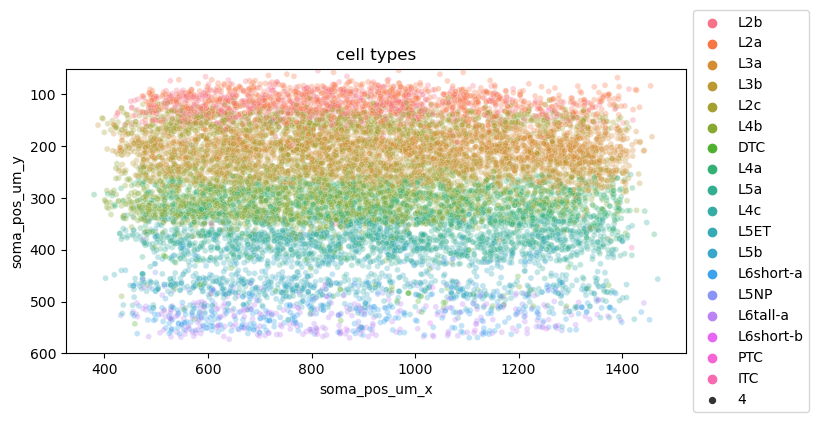

In [18]:
f, ax = plt.subplots(figsize=(8,8))



sns.scatterplot(data=beh_dfm,
 x='soma_pos_um_x', y='soma_pos_um_y', hue='cell_type', size=4,alpha=.3, ax=ax)

# sns.scatterplot(data=beh_dfm.query('session==9').query('scan_idx==6'),
#  x='soma_pos_um_x', y='soma_pos_um_y', linewidth=0, c='k',
#    size=1.5,alpha=1, ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))



ax.set_ylim(600, 50)
ax.set_aspect('equal')
ax.set_title('cell types')

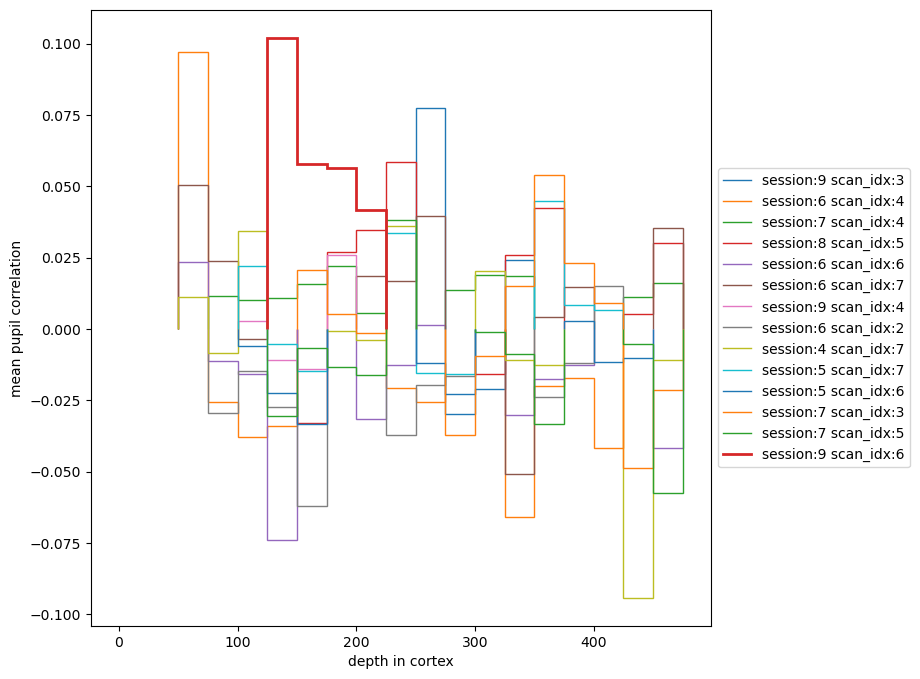

In [19]:
f, ax = plt.subplots(figsize=(8,8))

bins = np.arange(0,500,25)

for session, scan_idx in beh_dfm[['session', 'scan_idx']].value_counts().index:
    dft = beh_dfm.query(f'session=={session}').query(f'scan_idx=={scan_idx}')
    binn_pupil_corr, edges, _ = scipy.stats.binned_statistic(dft.soma_pos_um_y, dft.pupil_corr, bins=bins, statistic='mean')
    binn_pupil_corr_std, edges, _ = scipy.stats.binned_statistic(dft.soma_pos_um_y, dft.pupil_corr, bins=bins, statistic='std')
    binn_pupil_corr_N, edges, _ = scipy.stats.binned_statistic(dft.soma_pos_um_y, dft.pupil_corr, bins=bins, statistic='count')

    linewidth=1
    if session ==9:
        if scan_idx==6:
            linewidth=2
    ax.stairs(binn_pupil_corr, edges, label=f'session:{session} scan_idx:{scan_idx}', linewidth=linewidth)
    #ax.stairs(binn_pupil_corr+binn_pupil_corr_std/np.sqrt(binn_pupil_corr_N), edges)
    #ax.stairs(binn_pupil_corr-binn_pupil_corr_std/np.sqrt(binn_pupil_corr_N), edges)
#ax.stairs(binn_pupil_corr_std, edges)
ax.set_ylabel('mean pupil correlation')
ax.set_xlabel('depth in cortex')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


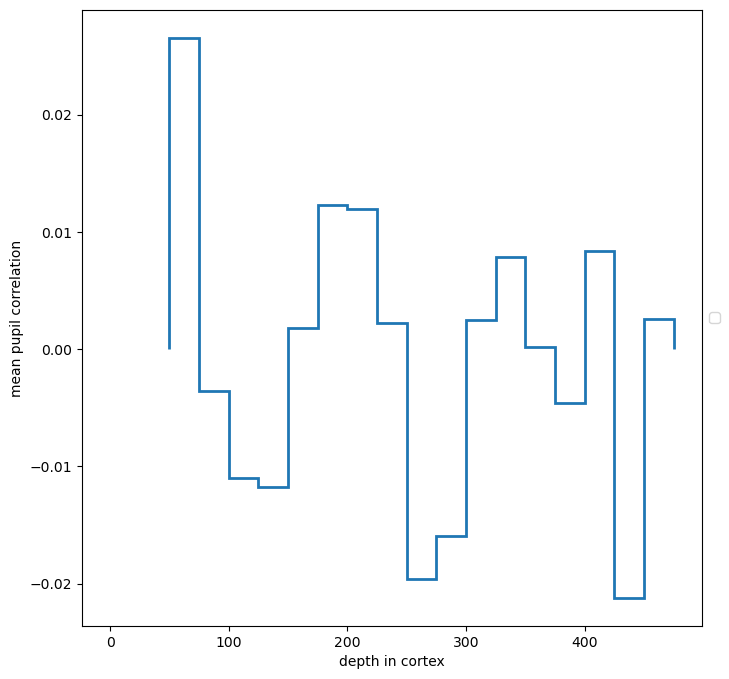

In [21]:
f, ax = plt.subplots(figsize=(8,8))

bins = np.arange(0,500,25)

dft = beh_dfm[(beh_dfm.session!=9) & (beh_dfm.scan_idx!=6)]
binn_pupil_corr, edges, _ = scipy.stats.binned_statistic(dft.soma_pos_um_y, dft.pupil_corr, bins=bins, statistic='mean')
binn_pupil_corr_std, edges, _ = scipy.stats.binned_statistic(dft.soma_pos_um_y, dft.pupil_corr, bins=bins, statistic='std')
binn_pupil_corr_N, edges, _ = scipy.stats.binned_statistic(dft.soma_pos_um_y, dft.pupil_corr, bins=bins, statistic='count')

ax.stairs(binn_pupil_corr, edges, linewidth=2)
#ax.stairs(binn_pupil_corr-binn_pupil_corr_std/np.sqrt(binn_pupil_corr_N), edges)
#ax.stairs(binn_pupil_corr_std, edges)
ax.set_ylabel('mean pupil correlation')
ax.set_xlabel('depth in cortex')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


In [22]:
(beh_dfm.session!=9) & (beh_dfm.scan_idx!=6)

0        True
1        True
2        True
3        True
4        True
         ... 
13425    True
13426    True
13427    True
13428    True
13429    True
Length: 13430, dtype: bool

In [28]:
bins

array([  0,  25,  50,  75, 100, 125, 150, 175, 200, 225, 250, 275, 300,
       325, 350, 375, 400, 425, 450, 475])

0        4_7
1        4_7
2        4_7
3        4_7
4        4_7
        ... 
13425    7_3
13426    7_3
13427    7_3
13428    7_3
13429    7_3
Name: session_scan_comb, Length: 13430, dtype: object

<Axes: xlabel='session_scan_comb', ylabel='pupil_corr'>

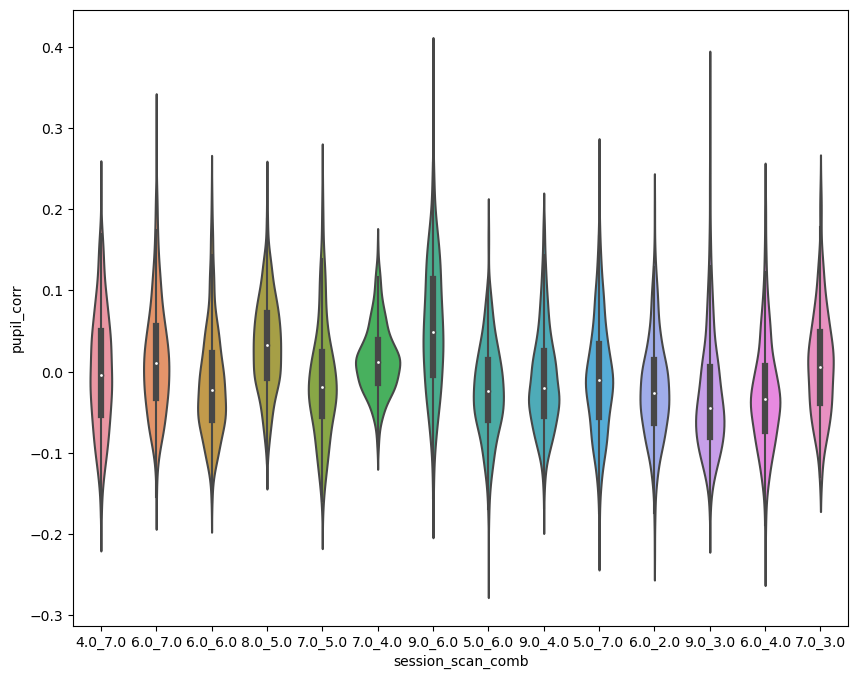

In [43]:
f, ax = plt.subplots(figsize=(10,8))
sns.violinplot(x='session_scan_comb', y='pupil_corr', data=upper_beh_cells,ax=ax)

In [29]:
sns.violinplot?

Signature:
sns.violinplot(
    data=None,
    *,
    x=None,
    y=None,
    hue=None,
    order=None,
    hue_order=None,
    bw='scott',
    cut=2,
    scale='area',
    scale_hue=True,
    gridsize=100,
    width=0.8,
    inner='box',
    split=False,
    dodge=True,
    orient=None,
    linewidth=None,
    color=None,
    palette=None,
    saturation=0.75,
    ax=None,
    **kwargs,
)
Docstring:
Draw a combination of boxplot and kernel density estimate.

A violin plot plays a similar role as a box and whisker plot. It shows the
distribution of quantitative data across several levels of one (or more)
categorical variables such that those distributions can be compared. Unlike
a box plot, in which all of the plot components correspond to actual
datapoints, the violin plot features a kernel density estimation of the
underlying distribution.

This can be an effective and attractive way to show multiple distributions
of data at once, but keep in mind that the estimation procedure is
infl

In [24]:
beh_dfm[['session', 'scan_idx']].value_counts()

session  scan_idx
9        3           1163
6        4           1147
7        4           1145
8        5           1115
6        6           1049
         7           1024
9        4           1024
6        2           1014
4        7           1013
5        7            996
         6            993
7        3            740
         5            626
9        6            381
Name: count, dtype: int64

In [22]:
beh_dfm.columns

Index(['pt_root_id', 'session', 'scan_idx', 'running_corr', 'pupil_corr',
       'soma_id', 'soma_center_mass', 'soma_volume_nm', 'soma_area_nm',
       'soma_area_to_volume', 'n_soma_syn', 'soma_syn_density', 'frac_zero',
       'nucleus_id', 'is_watertight', 'nucleus_center_mass',
       'nucleus_avg_radius', 'nucleus_volume_nm', 'nucleus_area_nm',
       'nucleus_area_to_volume_ratio', 'nucleus_aspect_ratio',
       'nucleus_is_clipped', 'fold_area_nm', 'fract_fold', 'avg_fold_depth',
       'soma_nuc_d', 'nucleus_to_soma', 'nuc_id', 'soma_volume_um',
       'cell_type', 'classification_system', 'volume', 'target_id',
       'soma_pos_um_x', 'soma_pos_um_y', 'soma_pos_um_z'],
      dtype='object')

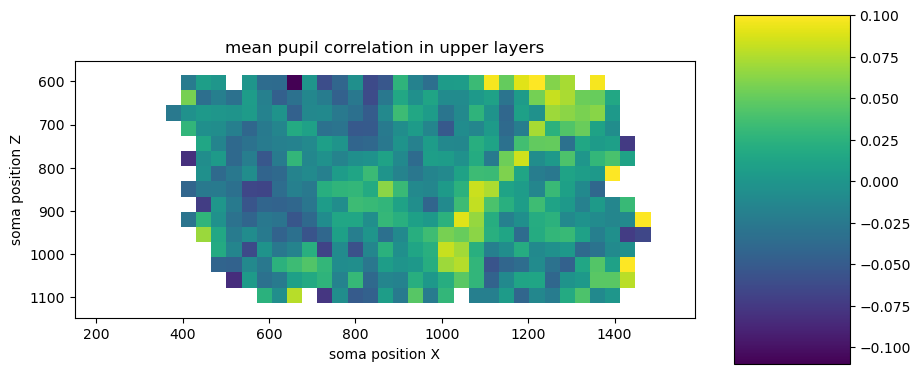

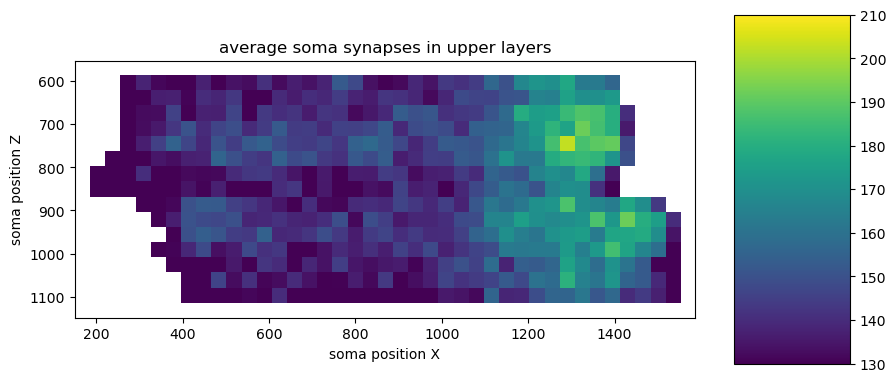

In [66]:

mean_pupil_map,x_edges,y_edges, _ = scipy.stats.binned_statistic_2d(upper_beh_cells.soma_pos_um_x, 
                                upper_beh_cells.soma_pos_um_z,
                                upper_beh_cells.pupil_corr, statistic='mean', bins=[binx, biny])

f ,ax = plt.subplots(figsize=(10,10))
M=ax.imshow(mean_pupil_map.T, extent=[binx[0], binx[-1], biny[-1], biny[0]], vmax=-.1,vmin=.1)
ax.set_aspect('equal')
ax.set_title('mean pupil correlation in upper layers')
ax.set_xlabel('soma position X')
ax.set_ylabel('soma position Z')
f.colorbar(M, aspect=3)


f ,ax = plt.subplots(figsize=(10,10))
M=ax.imshow(mean_soma_map.T, extent=[binx[0], binx[-1], biny[-1], biny[0]], vmax=210,vmin=130)
ax.set_aspect('equal')
ax.set_title('average soma synapses in upper layers')
ax.set_xlabel('soma position X')
ax.set_ylabel('soma position Z')
f.colorbar(M, aspect=3)


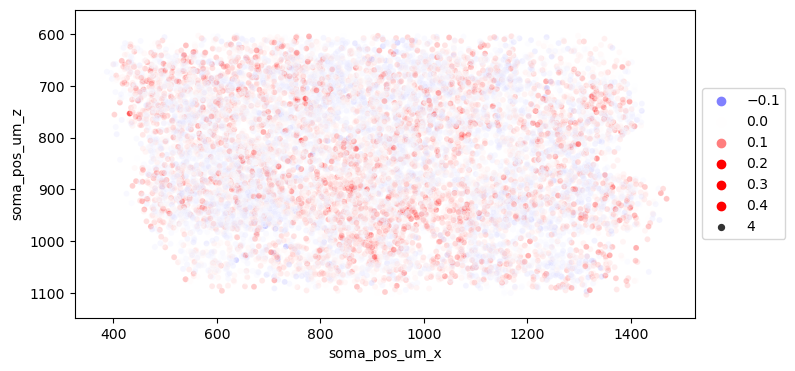

In [67]:
f, ax = plt.subplots(figsize=(8,8))

sns.scatterplot(data=beh_dfm,
 x='soma_pos_um_x', y='soma_pos_um_z', hue='running_corr',
  palette=plt.cm.bwr, size=4,alpha=.3,
  hue_norm = (-.2,.2), ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_ylim(biny[-1], biny[0])
ax.set_aspect('equal')

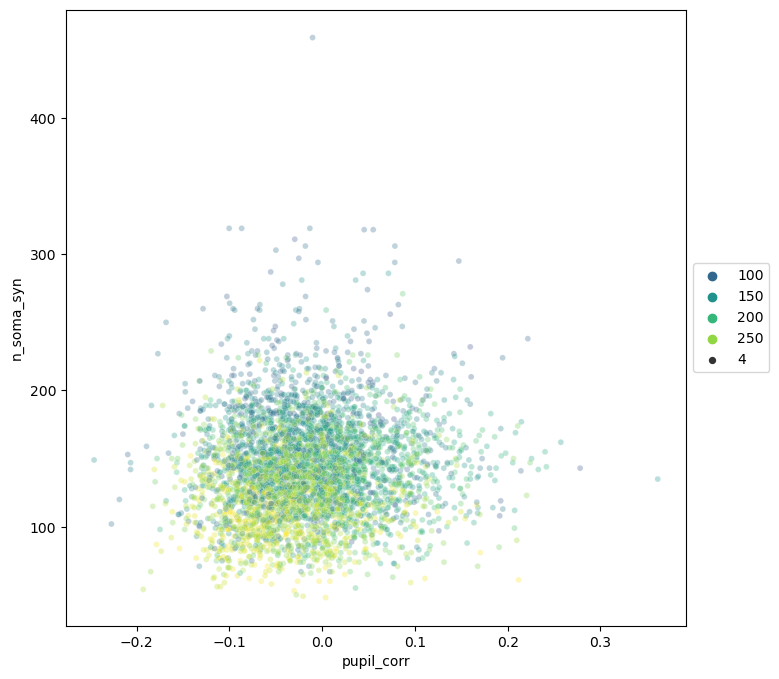

In [70]:
f, ax = plt.subplots(figsize=(8,8))

sns.scatterplot(data=upper_beh_cells.query('soma_pos_um_x<900'),
 x='pupil_corr', y='n_soma_syn', hue='soma_pos_um_y',
  palette=plt.cm.viridis, size=4,alpha=.3,
  hue_norm = (0,300), ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))



In [47]:
np.corrcoef(beh_dfm.pupil_corr, beh_dfm.n_soma_syn)

array([[1.       , 0.0387751],
       [0.0387751, 1.       ]])

In [44]:
beh_dfm.classification_system.value_counts()

classification_system
excitatory_neuron    13352
inhibitory_neuron       78
Name: count, dtype: int64